In [3]:
print("hi l")

hi l


In [15]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn
import pandas as pd

def load_model(model_name="HuggingFaceTB/SmolLM-360M-Instruct"):
    """Load model and tokenizer."""
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return model, tokenizer

def print_model_structure(model):
    """Print detailed structure of the model."""
    print("Model Structure:")
    print("---------------")
    for name, module in model.named_modules():
        if name:  # Skip empty names
            print(f"\nLayer: {name}")
            print(f"Type: {type(module).__name__}")
            if hasattr(module, 'in_features') and hasattr(module, 'out_features'):
                print(f"Dimensions: {module.in_features} → {module.out_features}")

def analyze_layer_weights(model):
    """Analyze weights of each layer."""
    stats = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:  # Only look at trainable parameters
            stats.append({
                'layer': name,
                'shape': tuple(param.shape),
                'mean': param.data.mean().item(),
                'std': param.data.std().item(),
                'min': param.data.min().item(),
                'max': param.data.max().item(),
                'num_params': param.numel()
            })
    
    return pd.DataFrame(stats)

def visualize_weight_distribution(model, layer_name):
    """Plot weight distribution for a specific layer."""
    param = dict(model.named_parameters())[layer_name].data
    weights = param.flatten().cpu().numpy()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(weights, bins=50, kde=True)
    plt.title(f'Weight Distribution for {layer_name}')
    plt.xlabel('Weight Value')
    plt.ylabel('Count')
    plt.show()

def plot_attention_pattern(model, text, tokenizer, layer_idx=0, head_idx=0):
    """
    Visualize attention patterns for a given input.
    
    Args:
        model: The model
        text: Input text
        tokenizer: The tokenizer
        layer_idx: Which layer to visualize (default: 0)
        head_idx: Which attention head to visualize (default: 0)
    """
    # Tokenize input and get token strings for labels
    inputs = tokenizer(text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    
    # Get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        # Shape: (batch_size, num_heads, seq_length, seq_length)
        attention = outputs.attentions[layer_idx][0]  # Get first batch
        
        # Extract specific head's attention pattern
        attention_head = attention[head_idx].cpu().numpy()
    
    # Create plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_head, 
                cmap='viridis',
                xticklabels=tokens,
                yticklabels=tokens)
    plt.title(f'Attention Pattern (Layer {layer_idx}, Head {head_idx})')
    plt.xlabel('Key tokens')
    plt.ylabel('Query tokens')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_multi_head_attention(model, text, tokenizer, layer_idx=0, max_heads=4):
    """
    Visualize multiple attention heads in a grid.
    
    Args:
        model: The model
        text: Input text
        tokenizer: The tokenizer
        layer_idx: Which layer to visualize (default: 0)
        max_heads: Maximum number of heads to show (default: 4)
    """
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    
    # Get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attention = outputs.attentions[layer_idx][0]  # Get first batch
        
    # Determine grid size
    num_heads = min(attention.shape[0], max_heads)
    grid_size = int(np.ceil(np.sqrt(num_heads)))
    
    # Create subplots
    fig, axes = plt.subplots(grid_size, grid_size, 
                            figsize=(15, 15),
                            squeeze=False)
    fig.suptitle(f'Attention Patterns in Layer {layer_idx}', fontsize=16)
    
    # Plot each head
    for idx in range(num_heads):
        row = idx // grid_size
        col = idx % grid_size
        attention_head = attention[idx].cpu().numpy()
        
        sns.heatmap(attention_head,
                    cmap='viridis',
                    xticklabels=tokens,
                    yticklabels=tokens,
                    ax=axes[row, col])
        axes[row, col].set_title(f'Head {idx}')
        axes[row, col].set_xticklabels(tokens, rotation=45, ha='right')
        axes[row, col].set_yticklabels(tokens, rotation=0)
    
    # Remove empty subplots if any
    for idx in range(num_heads, grid_size * grid_size):
        row = idx // grid_size
        col = idx % grid_size
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()

def find_largest_layers(model, top_n=5):
    """Find the layers with the most parameters."""
    layer_sizes = {}
    for name, param in model.named_parameters():
        layer_sizes[name] = param.numel()
    
    # Sort by size
    sorted_layers = sorted(layer_sizes.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop {top_n} largest layers:")
    for name, size in sorted_layers[:top_n]:
        print(f"{name}: {size:,} parameters")

def compare_layer_norms(model):
    """Analyze LayerNorm statistics across the model."""
    layernorm_stats = []
    
    for name, module in model.named_modules():
        if isinstance(module, nn.LayerNorm):
            layernorm_stats.append({
                'layer': name,
                'mean': module.weight.data.mean().item(),
                'std': module.weight.data.std().item(),
                'bias_mean': module.bias.data.mean().item() if module.bias is not None else 0
            })
    
    return pd.DataFrame(layernorm_stats)



In [6]:
model_names=["HuggingFaceTB/SmolLM-135M", "HuggingFaceTB/SmolLM-360M",
                  "HuggingFaceTB/SmolLM-1.7B", "HuggingFaceTB/SmolLM-360M-Instruct",
                    "HuggingFaceTB/SmolLM-1.7B-Instruct"]
# Load model
model, tokenizer = load_model(model_names[0])

# Print model structure
print_model_structure(model)


Model Structure:
---------------

Layer: model
Type: LlamaModel

Layer: model.embed_tokens
Type: Embedding

Layer: model.layers
Type: ModuleList

Layer: model.layers.0
Type: LlamaDecoderLayer

Layer: model.layers.0.self_attn
Type: LlamaSdpaAttention

Layer: model.layers.0.self_attn.q_proj
Type: Linear
Dimensions: 576 → 576

Layer: model.layers.0.self_attn.k_proj
Type: Linear
Dimensions: 576 → 192

Layer: model.layers.0.self_attn.v_proj
Type: Linear
Dimensions: 576 → 192

Layer: model.layers.0.self_attn.o_proj
Type: Linear
Dimensions: 576 → 576

Layer: model.layers.0.self_attn.rotary_emb
Type: LlamaRotaryEmbedding

Layer: model.layers.0.mlp
Type: LlamaMLP

Layer: model.layers.0.mlp.gate_proj
Type: Linear
Dimensions: 576 → 1536

Layer: model.layers.0.mlp.up_proj
Type: Linear
Dimensions: 576 → 1536

Layer: model.layers.0.mlp.down_proj
Type: Linear
Dimensions: 1536 → 576

Layer: model.layers.0.mlp.act_fn
Type: SiLU

Layer: model.layers.0.input_layernorm
Type: LlamaRMSNorm

Layer: model.lay

In [8]:
# Get weight statistics
stats_df = analyze_layer_weights(model)
display(stats_df)


,layer,shape,mean,std,min,max,num_params
0,model.embed_tokens.weight,"(49152, 576)",-0.001834,0.187635,-1.953125,3.984375,28311552
1,model.layers.0.self_attn.q_proj.weight,"(576, 576)",-0.000464,0.212381,-11.000000,5.406250,331776
2,model.layers.0.self_attn.k_proj.weight,"(192, 576)",-0.000520,0.328813,-7.937500,6.500000,110592
3,model.layers.0.self_attn.v_proj.weight,"(192, 576)",0.000012,0.039738,-0.447266,0.443359,110592
4,model.layers.0.self_attn.o_proj.weight,"(576, 576)",-0.000070,0.063871,-3.171875,3.046875,331776
...,...,...,...,...,...,...,...
267,model.layers.29.mlp.up_proj.weight,"(1536, 576)",-0.000172,0.275493,-4.468750,2.843750,884736
268,model.layers.29.mlp.down_proj.weight,"(576, 1536)",0.000320,0.245682,-6.125000,5.062500,884736
269,model.layers.29.input_layernorm.weight,"(576,)",0.350811,0.033340,0.192383,0.734375,576
270,model.layers.29.post_attention_layernorm.weight,"(576,)",0.311483,0.056267,0.271484,0.968750,576


In [19]:
stats_df.layer.unique()

array(['model.embed_tokens.weight',
       'model.layers.0.self_attn.q_proj.weight',
       'model.layers.0.self_attn.k_proj.weight',
       'model.layers.0.self_attn.v_proj.weight',
       'model.layers.0.self_attn.o_proj.weight',
       'model.layers.0.mlp.gate_proj.weight',
       'model.layers.0.mlp.up_proj.weight',
       'model.layers.0.mlp.down_proj.weight',
       'model.layers.0.input_layernorm.weight',
       'model.layers.0.post_attention_layernorm.weight',
       'model.layers.1.self_attn.q_proj.weight',
       'model.layers.1.self_attn.k_proj.weight',
       'model.layers.1.self_attn.v_proj.weight',
       'model.layers.1.self_attn.o_proj.weight',
       'model.layers.1.mlp.gate_proj.weight',
       'model.layers.1.mlp.up_proj.weight',
       'model.layers.1.mlp.down_proj.weight',
       'model.layers.1.input_layernorm.weight',
       'model.layers.1.post_attention_layernorm.weight',
       'model.layers.2.self_attn.q_proj.weight',
       'model.layers.2.self_attn.k_proj.w

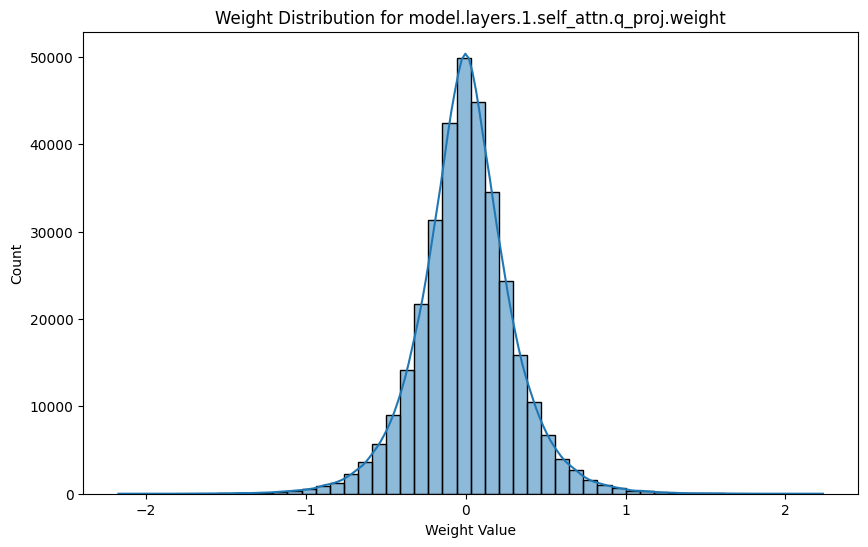

In [11]:
# Plot weight distribution for a specific layer
visualize_weight_distribution(model, "model.layers.1.self_attn.q_proj.weight")

In [12]:
# Find largest layers
find_largest_layers(model)



Top 5 largest layers:
model.embed_tokens.weight: 28,311,552 parameters
model.layers.0.mlp.gate_proj.weight: 884,736 parameters
model.layers.0.mlp.up_proj.weight: 884,736 parameters
model.layers.0.mlp.down_proj.weight: 884,736 parameters
model.layers.1.mlp.gate_proj.weight: 884,736 parameters


In [ ]:
# Single head visualization
plot_attention_pattern(model, "Hello, how are you?", tokenizer, layer_idx=27)

# Multi-head visualization
plot_multi_head_attention(model, "Hello, how are you?", tokenizer, layer_idx=27)

# Compare different layers
for layer_idx in [19, 25, 29]:  # Key semantic layers
    print(f"\nLayer {layer_idx} attention patterns:")
    plot_multi_head_attention(model, "Hello, how are you?", tokenizer, layer_idx=layer_idx)

In [ ]:
# Example paths to investigate
key_layers = [
    # Upper intermediate MLPs
    "model.layers.19.mlp",
    "model.layers.20.mlp",
    "model.layers.21.mlp",
    
    # Higher layer attention and MLPs
    "model.layers.27.self_attn",
    "model.layers.28.self_attn",
    "model.layers.29.self_attn",
    "model.layers.27.mlp",
    "model.layers.28.mlp",
    "model.layers.29.mlp"
]

In [20]:
# Analyze layer 20 MLP weights
print("=== Layer 20 MLP Analysis ===")
mlp_weights = {
    'gate': model.state_dict()['model.layers.20.mlp.gate_proj.weight'],
    'up': model.state_dict()['model.layers.20.mlp.up_proj.weight'],
    'down': model.state_dict()['model.layers.20.mlp.down_proj.weight']
}

for name, weight in mlp_weights.items():
    print(f"\n{name}_proj:")
    print(f"- Shape: {weight.shape}")
    print(f"- Number of parameters: {weight.numel():,}")
    print(f"- Data type: {weight.dtype}")
    print(f"- Mean: {weight.mean().item():.6f}")
    print(f"- Std: {weight.std().item():.6f}")

# Analyze layer 28 attention weights
print("\n=== Layer 28 Attention Analysis ===")
attn_weights = {
    'q': model.state_dict()['model.layers.28.self_attn.q_proj.weight'],
    'k': model.state_dict()['model.layers.28.self_attn.k_proj.weight'],
    'v': model.state_dict()['model.layers.28.self_attn.v_proj.weight'],
    'o': model.state_dict()['model.layers.28.self_attn.o_proj.weight']
}

for name, weight in attn_weights.items():
    print(f"\n{name}_proj:")
    print(f"- Shape: {weight.shape}")
    print(f"- Number of parameters: {weight.numel():,}")
    print(f"- Data type: {weight.dtype}")
    print(f"- Mean: {weight.mean().item():.6f}")
    print(f"- Std: {weight.std().item():.6f}")

=== Layer 20 MLP Analysis ===

gate_proj:
- Shape: torch.Size([1536, 576])
- Number of parameters: 884,736
- Data type: torch.float32
- Mean: 0.000409
- Std: 0.240053

up_proj:
- Shape: torch.Size([1536, 576])
- Number of parameters: 884,736
- Data type: torch.float32
- Mean: -0.000205
- Std: 0.259336

down_proj:
- Shape: torch.Size([576, 1536])
- Number of parameters: 884,736
- Data type: torch.float32
- Mean: -0.000241
- Std: 0.248924

=== Layer 28 Attention Analysis ===

q_proj:
- Shape: torch.Size([576, 576])
- Number of parameters: 331,776
- Data type: torch.float32
- Mean: -0.001195
- Std: 0.204408

k_proj:
- Shape: torch.Size([192, 576])
- Number of parameters: 110,592
- Data type: torch.float32
- Mean: -0.000368
- Std: 0.172649

v_proj:
- Shape: torch.Size([192, 576])
- Number of parameters: 110,592
- Data type: torch.float32
- Mean: -0.001585
- Std: 0.360189

o_proj:
- Shape: torch.Size([576, 576])
- Number of parameters: 331,776
- Data type: torch.float32
- Mean: -0.000189
- 

In [32]:
import torch
from torch.linalg import svd
import matplotlib.pyplot as plt

def low_rank_approximation_and_sample(weight_matrix, rank=10, scale=0.01):
    """
    Create low-rank approximation and sample new weights.
    
    Args:
        weight_matrix: Original weight matrix
        rank: Rank for approximation
        scale: Scale of the Gaussian noise
    
    Returns:
        Sampled weight matrix of same shape as original
    """
    # Compute SVD
    U, S, Vh = svd(weight_matrix)
    
    # Keep only top-k singular values/vectors
    U_k = U[:, :rank]
    S_k = S[:rank]
    V_k = Vh[:rank, :]
    
    # Sample perturbations for singular values
    # Using diagonal normal distribution for simplicity
    S_noise = torch.randn_like(S_k) * scale
    perturbed_S = S_k + S_noise
    
    # Reconstruct with perturbed singular values
    sampled_weights = U_k @ torch.diag(perturbed_S) @ V_k
    
    return sampled_weights, (U_k, S_k, V_k)



Original weights:
Shape: torch.Size([192, 576])
Mean: -0.000368
Std: 0.172649

Sampled weights:
Shape: torch.Size([192, 576])
Mean: 0.000085
Std: 0.138220


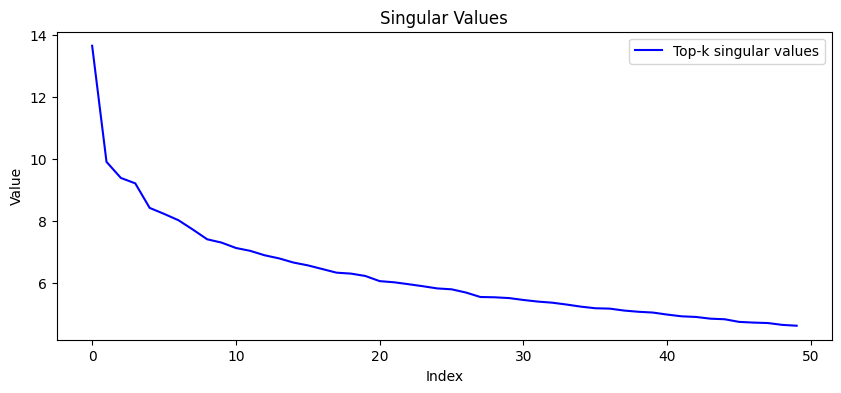

In [33]:
# Let's use it on k_proj weights
original_weights = model.state_dict()['model.layers.28.self_attn.k_proj.weight']

# Generate a sample
sampled_weights, (U_k, S_k, V_k) = low_rank_approximation_and_sample(original_weights, rank=50)

# Print statistics to compare
print("Original weights:")
print(f"Shape: {original_weights.shape}")
print(f"Mean: {original_weights.mean():.6f}")
print(f"Std: {original_weights.std():.6f}")

print("\nSampled weights:")
print(f"Shape: {sampled_weights.shape}")
print(f"Mean: {sampled_weights.mean():.6f}")
print(f"Std: {sampled_weights.std():.6f}")

# Plot singular values to see how many we might need
plt.figure(figsize=(10, 4))
plt.plot(S_k.cpu().numpy(), 'b-', label='Top-k singular values')
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [37]:
import torch
from torch.linalg import svd, eigh

def laplace_low_rank_perturbation(weight_matrix, rank=10, prior_scale=0.01):
    """
    Perturb weight matrix using Laplace approximation with low-rank Hessian.

    Args:
        weight_matrix (torch.Tensor): Original weight matrix.
        rank (int): Number of components for low-rank approximation.
        prior_scale (float): Variance scale for Gaussian prior.
        
    Returns:
        perturbed_weights (torch.Tensor): Perturbed weight matrix.
        (U_k, S_k, V_k): Low-rank decomposition components.
    """
    # Step 1: Compute SVD of weight matrix for initialization
    U, S, Vh = svd(weight_matrix)
    
    # Step 2: Approximate the Hessian (e.g., using diagonal or low-rank)
    # For simplicity, we'll assume Hessian = (Empirical Fisher + Prior Hessian)
    # Use eigen decomposition to simulate curvature (random approximation)
    H_approx = torch.randn((weight_matrix.shape[0], weight_matrix.shape[0]))
    H_approx = (H_approx + H_approx.T) / 2  # Symmetrize
    Lambda, U_hessian = eigh(H_approx)  # Eigen decomposition (corrected)
    
    # Keep top-k components for low-rank approximation
    Lambda_k = Lambda[-rank:]
    U_k = U_hessian[:, -rank:]
    
    # Step 3: Compute covariance approximation
    inv_sqrt_Lambda_k = torch.sqrt(1.0 / (Lambda_k + prior_scale))
    noise_covariance = U_k @ torch.diag(inv_sqrt_Lambda_k) @ U_k.T
    
    # Step 4: Sample noise from the covariance
    z = torch.randn_like(weight_matrix)
    noise = noise_covariance @ z
    
    # Step 5: Add perturbation to the weight matrix
    perturbed_weights = weight_matrix + noise
    
    return perturbed_weights, (U, S, Vh)


Original weights:
Shape: torch.Size([192, 576])
Mean: -0.000368
Std: 0.172649

Sampled weights:
Shape: torch.Size([192, 576])
Mean: -0.000496
Std: 0.181869


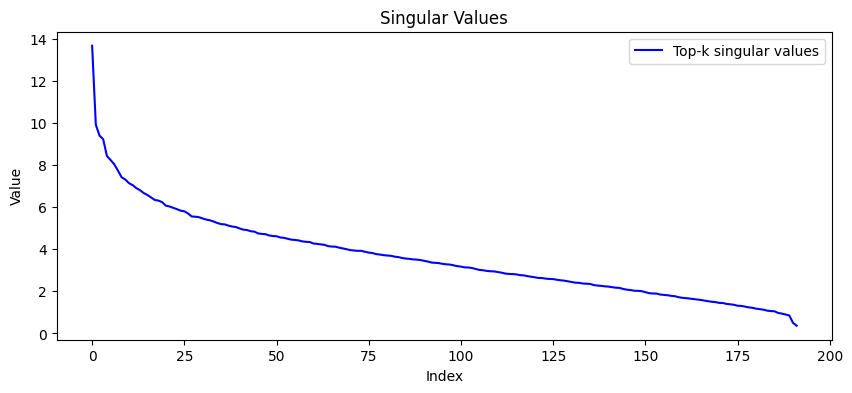

In [40]:
# Let's use it on k_proj weights
original_weights = model.state_dict()['model.layers.28.self_attn.k_proj.weight']

# Generate a sample
sampled_weights, (U_k, S_k, V_k) = laplace_low_rank_perturbation(original_weights, rank=10)

# Print statistics to compare
print("Original weights:")
print(f"Shape: {original_weights.shape}")
print(f"Mean: {original_weights.mean():.6f}")
print(f"Std: {original_weights.std():.6f}")

print("\nSampled weights:")
print(f"Shape: {sampled_weights.shape}")
print(f"Mean: {sampled_weights.mean():.6f}")
print(f"Std: {sampled_weights.std():.6f}")

# Plot singular values to see how many we might need
plt.figure(figsize=(10, 4))
plt.plot(S_k.cpu().numpy(), 'b-', label='Top-k singular values')
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [47]:
import torch
from torch.linalg import svd, eigh

def laplace_low_rank_perturbation(weight_matrix, rank=10, prior_scale=0.01):
    """
    Perturb weight matrix using Laplace approximation with low-rank Hessian.
    """
    m, n = weight_matrix.shape
    
    # Step 1: SVD of weight matrix
    U, S, Vh = svd(weight_matrix)
    
    # Step 2: Create random Hessian approximation
    # Make it smaller using the rank
    H_approx = torch.randn((rank, rank))
    H_approx = (H_approx + H_approx.T) / 2  # Symmetrize
    Lambda, U_hessian = eigh(H_approx)
    
    # Ensure positive eigenvalues
    Lambda = torch.abs(Lambda) + prior_scale
    
    # Step 3: Create noise in low-rank space
    inv_sqrt_Lambda = torch.sqrt(1.0 / Lambda)
    noise_low_rank = U_hessian @ (torch.diag(inv_sqrt_Lambda) @ (torch.randn(rank)))
    
    # Step 4: Project noise to original space using SVD components
    U_k = U[:, :rank]
    V_k = Vh[:rank, :]
    noise = U_k @ torch.diag(noise_low_rank) @ V_k
    
    # Step 5: Add perturbation
    perturbed_weights = weight_matrix + noise
    
    return perturbed_weights, (U, S, Vh)

# Test it
if __name__ == "__main__":
    # Get weights from model
    W = model.state_dict()['model.layers.28.self_attn.k_proj.weight']
    
    # Generate samples
    n_samples = 3
    for i in range(n_samples):
        perturbed_W, _ = laplace_low_rank_perturbation(W, rank=10)
        print(f"\nSample {i+1} stats:")
        print(f"Mean: {perturbed_W.mean():.6f}")
        print(f"Std: {perturbed_W.std():.6f}")
        print("First few values:", perturbed_W[0][:5].tolist())
        
        # Check difference from original
        diff = (perturbed_W - W).abs().mean()
        print(f"Average absolute difference: {diff:.6f}")



Sample 1 stats:
Mean: -0.000375
Std: 0.174643
First few values: [-0.09157496690750122, -0.18715912103652954, 0.005210421048104763, 0.1483086198568344, 0.22232207655906677]
Average absolute difference: 0.006463

Sample 2 stats:
Mean: -0.000399
Std: 0.171076
First few values: [-0.09552844613790512, -0.18928904831409454, 0.005944462027400732, 0.14183376729488373, 0.2208542823791504]
Average absolute difference: 0.006138

Sample 3 stats:
Mean: -0.000360
Std: 0.176757
First few values: [-0.09788097441196442, -0.19165486097335815, 0.005212635267525911, 0.14825522899627686, 0.22745294868946075]
Average absolute difference: 0.008492


In [61]:
def generate_with_multi_layer_samples(model, tokenizer, layer_names, text, 
                                    n_samples=3, rank=10, prior_scale=0.01, 
                                    max_length=100, temp=0.0):
    """
    Generate text using model with weights sampled simultaneously across multiple layers.
    """
    results = []
    
    # Store original weights for all layers
    original_states = {
        layer: model.state_dict()[layer].clone()
        for layer in layer_names
    }
    
    # Generate with original weights
    print(f"Original generation:")
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            pad_token_id=tokenizer.eos_token_id,
            num_return_sequences=1,
            temperature=temp,
        )
    original_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(original_text)
    
    # Generate samples with multiple layer perturbations
    for i in range(n_samples):
        # Sample new weights for each layer
        for layer_name in layer_names:
            original_weights = original_states[layer_name]
            sampled_weights, _ = laplace_low_rank_perturbation(original_weights, rank, prior_scale)
            # Replace weights in model
            model.state_dict()[layer_name].copy_(sampled_weights)
        
        print(f"\nSample {i+1} generation:")
        # Generate with all perturbed layers
        with torch.no_grad():
            outputs = model.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_length=max_length,
                pad_token_id=tokenizer.eos_token_id,
                num_return_sequences=1,
                temperature=temp,
            )
        
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(generated_text)
        results.append(generated_text)
    
    # Restore all original weights
    for layer_name, original_state in original_states.items():
        model.state_dict()[layer_name].copy_(original_state)
    
    return original_text, results

prompt = "The capital of France is London."

# Try with more varied layers and parameters
layer_names = [
    # More attention layers from upper layers
    'model.layers.28.self_attn.q_proj.weight',  # Added query projection
    'model.layers.28.self_attn.k_proj.weight',
    'model.layers.28.self_attn.v_proj.weight',
    'model.layers.28.self_attn.o_proj.weight',  # Added output projection
    'model.layers.29.self_attn.q_proj.weight'
]
layer_names = [
    # More attention layers from upper layers
    'model.layers.28.self_attn.q_proj.weight'
]

original, samples = generate_with_multi_layer_samples(
    model=model,
    tokenizer=tokenizer,
    layer_names=layer_names,
    text=prompt,
    n_samples=8,
    rank=2,          # Increased rank
    prior_scale=0.1, # Increased scale
    max_length=50,   # Reduced max length
    temp=0.0
)

Original generation:
The capital of France is London.
The capital of the United States is Washington, D.C.
The capital of the United Kingdom is London.
The capital of the United States is Washington, D.C.
The capital of the

Sample 1 generation:
The capital of France is London.
The capital of the United States is Washington, D.C.
The capital of the United Kingdom is London.
The capital of the United States is Washington, D.C.
The capital of the

Sample 2 generation:
The capital of France is London.
The capital of the United States is Washington, D.C.
The capital of the United Kingdom is London.
The capital of the United States is Washington, D.C.
The capital of the

Sample 3 generation:
The capital of France is London.
The capital of the United States is Washington, D.C.
The capital of the United Kingdom is London.
The capital of the United States is Washington, D.C.
The capital of the

Sample 4 generation:
The capital of France is London.
The capital of the United States is Washington